### Data Preparation

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
pd.read_csv('extensive_dataset.csv')

,No,F stat.,Strain stat,Stress stat,Lo,Lm,F dyn.,Strain dyn,Stress dyn,Time,f,T,E',E'',|E*|,tan ä,F cont.,T2,T3,|J*|
0,,N,%,MPa,mm,mm,N,%,MPa,sec,Hz,°C,MPa,MPa,MPa,NaN,N,°C,°C,1/MPa
1,1,4.78481,0.301286,2.08792,2.26414,2.1838,0.778989,0.0470179,0.339922,9.68E+02,0.1,26.7,7.22E+02,33.92465,7.23E+02,0.046980,0.726986,---,---,1.38E-03
2,2,4.15294,0.167509,1.81219,2.24064,2.19597,0.78377,0.0470872,0.342009,1.40E+03,0.17609,25.8,7.26E+02,28.88208,7.26E+02,0.039800,0.822842,---,---,1.38E-03
3,3,4.15392,0.169736,1.81262,2.24177,2.1965,0.788822,0.0471716,0.344213,1.64E+03,0.31008,25.4,7.29E+02,28.14774,7.30E+02,0.038600,0.807583,---,---,1.37E-03
4,4,4.14512,0.171034,1.80878,2.24238,2.19677,0.78954,0.0470392,0.344527,1.79E+03,0.54601,25.1,7.32E+02,28.72457,7.32E+02,0.039250,0.817365,---,---,1.37E-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,1.04937,0.175751,0.457907,0.824722,0.777855,0.02027,0.046989,8.85E-03,2.52E+04,5.24974,150,17.6731,6.48028,18.8237,0.366674,0.988731,---,---,0.0531244
153,153,1.04742,0.173494,0.457056,0.825166,0.778901,0.0234622,0.04773,0.010238,2.52E+04,9.24425,149.8,19.9398,7.9059,21.4499,0.396489,0.987753,---,---,0.0466202
154,154,1.04644,0.17847,0.456628,0.826506,0.778914,0.0266739,0.0471866,0.0116395,2.52E+04,16.2782,150.1,22.6029,9.87773,24.667,0.437012,0.979732,---,---,0.0405401
155,155,1.05035,0.17802,0.458335,0.822343,0.774871,0.0313525,0.0472699,0.0136811,2.52E+04,28.6642,150.2,26.2371,12.2181,28.9425,0.465682,0.987361,---,---,0.0345513


In [4]:
data = data = pd.read_csv('extensive_dataset.csv')
data

,No,F stat.,Strain stat,Stress stat,Lo,Lm,F dyn.,Strain dyn,Stress dyn,Time,f,T,E',E'',|E*|,tan ä,F cont.,T2,T3,|J*|
0,,N,%,MPa,mm,mm,N,%,MPa,sec,Hz,°C,MPa,MPa,MPa,NaN,N,°C,°C,1/MPa
1,1,4.78481,0.301286,2.08792,2.26414,2.1838,0.778989,0.0470179,0.339922,9.68E+02,0.1,26.7,7.22E+02,33.92465,7.23E+02,0.046980,0.726986,---,---,1.38E-03
2,2,4.15294,0.167509,1.81219,2.24064,2.19597,0.78377,0.0470872,0.342009,1.40E+03,0.17609,25.8,7.26E+02,28.88208,7.26E+02,0.039800,0.822842,---,---,1.38E-03
3,3,4.15392,0.169736,1.81262,2.24177,2.1965,0.788822,0.0471716,0.344213,1.64E+03,0.31008,25.4,7.29E+02,28.14774,7.30E+02,0.038600,0.807583,---,---,1.37E-03
4,4,4.14512,0.171034,1.80878,2.24238,2.19677,0.78954,0.0470392,0.344527,1.79E+03,0.54601,25.1,7.32E+02,28.72457,7.32E+02,0.039250,0.817365,---,---,1.37E-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,152,1.04937,0.175751,0.457907,0.824722,0.777855,0.02027,0.046989,8.85E-03,2.52E+04,5.24974,150,17.6731,6.48028,18.8237,0.366674,0.988731,---,---,0.0531244
153,153,1.04742,0.173494,0.457056,0.825166,0.778901,0.0234622,0.04773,0.010238,2.52E+04,9.24425,149.8,19.9398,7.9059,21.4499,0.396489,0.987753,---,---,0.0466202
154,154,1.04644,0.17847,0.456628,0.826506,0.778914,0.0266739,0.0471866,0.0116395,2.52E+04,16.2782,150.1,22.6029,9.87773,24.667,0.437012,0.979732,---,---,0.0405401
155,155,1.05035,0.17802,0.458335,0.822343,0.774871,0.0313525,0.0472699,0.0136811,2.52E+04,28.6642,150.2,26.2371,12.2181,28.9425,0.465682,0.987361,---,---,0.0345513


In [5]:
cleaned_data = data.iloc[:, 7:14]
cleaned_data

,Strain dyn,Stress dyn,Time,f,T,E',E''
0,%,MPa,sec,Hz,°C,MPa,MPa
1,0.0470179,0.339922,9.68E+02,0.1,26.7,7.22E+02,33.92465
2,0.0470872,0.342009,1.40E+03,0.17609,25.8,7.26E+02,28.88208
3,0.0471716,0.344213,1.64E+03,0.31008,25.4,7.29E+02,28.14774
4,0.0470392,0.344527,1.79E+03,0.54601,25.1,7.32E+02,28.72457
...,...,...,...,...,...,...,...
152,0.046989,8.85E-03,2.52E+04,5.24974,150,17.6731,6.48028
153,0.04773,0.010238,2.52E+04,9.24425,149.8,19.9398,7.9059
154,0.0471866,0.0116395,2.52E+04,16.2782,150.1,22.6029,9.87773
155,0.0472699,0.0136811,2.52E+04,28.6642,150.2,26.2371,12.2181


In [6]:
cleaned_data.columns = ['Strain Dynamic (%)', 'Stress Dynamic (MPa)', 'Time (sec)', 'freq (Hz)', 'Temp (C)', "E' (MPa)", "E'' (MPa)"]

In [7]:
cleaned_data['Strain Dynamic (%)'] = pd.to_numeric(cleaned_data['Strain Dynamic (%)'], errors='coerce')
cleaned_data['Stress Dynamic (MPa)'] = pd.to_numeric(cleaned_data['Stress Dynamic (MPa)'], errors='coerce')
cleaned_data["Time (sec)"] = pd.to_numeric(cleaned_data["Time (sec)"], errors='coerce')
cleaned_data["freq (Hz)"] = pd.to_numeric(cleaned_data["freq (Hz)"], errors='coerce')
cleaned_data['Temp (C)'] = pd.to_numeric(cleaned_data['Temp (C)'], errors='coerce')
cleaned_data["E' (MPa)"] = pd.to_numeric(cleaned_data["E' (MPa)"], errors='coerce')
cleaned_data["E'' (MPa)"] = pd.to_numeric(cleaned_data["E'' (MPa)"], errors='coerce')

In [8]:
cleaned_data.dropna(how='all', inplace=True)
cleaned_data.ffill()

,Strain Dynamic (%),Stress Dynamic (MPa),Time (sec),freq (Hz),Temp (C),E' (MPa),E'' (MPa)
1,0.047018,0.339922,968.0,0.10000,26.7,722.0000,33.92465
2,0.047087,0.342009,1400.0,0.17609,25.8,726.0000,28.88208
3,0.047172,0.344213,1640.0,0.31008,25.4,729.0000,28.14774
4,0.047039,0.344527,1790.0,0.54601,25.1,732.0000,28.72457
5,0.047088,0.346514,1880.0,0.96147,25.0,735.0000,30.20620
...,...,...,...,...,...,...,...
152,0.046989,0.008850,25200.0,5.24974,150.0,17.6731,6.48028
153,0.047730,0.010238,25200.0,9.24425,149.8,19.9398,7.90590
154,0.047187,0.011640,25200.0,16.27820,150.1,22.6029,9.87773
155,0.047270,0.013681,25200.0,28.66420,150.2,26.2371,12.21810


In [9]:
cleaned_data

,Strain Dynamic (%),Stress Dynamic (MPa),Time (sec),freq (Hz),Temp (C),E' (MPa),E'' (MPa)
1,0.047018,0.339922,968.0,0.10000,26.7,722.0000,33.92465
2,0.047087,0.342009,1400.0,0.17609,25.8,726.0000,28.88208
3,0.047172,0.344213,1640.0,0.31008,25.4,729.0000,28.14774
4,0.047039,0.344527,1790.0,0.54601,25.1,732.0000,28.72457
5,0.047088,0.346514,1880.0,0.96147,25.0,735.0000,30.20620
...,...,...,...,...,...,...,...
152,0.046989,0.008850,25200.0,5.24974,150.0,17.6731,6.48028
153,0.047730,0.010238,25200.0,9.24425,149.8,19.9398,7.90590
154,0.047187,0.011640,25200.0,16.27820,150.1,22.6029,9.87773
155,0.047270,0.013681,25200.0,28.66420,150.2,26.2371,12.21810


In [25]:
X = cleaned_data[['Strain Dynamic (%)', 'Stress Dynamic (MPa)', 'Time (sec)', 'freq (Hz)', 'Temp (C)']].values
y = cleaned_data[["E' (MPa)"]].values

In [26]:
# Calculating the correlation of column A against all others
corr_matrix = cleaned_data.corr()["E' (MPa)"]
corr_matrix

Strain Dynamic (%)      0.139188
Stress Dynamic (MPa)    0.999896
Time (sec)             -0.968622
freq (Hz)               0.079635
Temp (C)               -0.974389
E' (MPa)                1.000000
E'' (MPa)               0.406209
Name: E' (MPa), dtype: float64

In [27]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=69)

In [28]:
y_train

array([[748.    ],
       [ 19.9398],
       [115.766 ],
       [647.    ],
       [686.    ],
       [721.    ],
       [701.    ],
       [620.    ],
       [725.    ],
       [437.489 ],
       [710.    ],
       [129.961 ],
       [479.038 ],
       [708.    ],
       [374.861 ],
       [595.    ],
       [ 33.8348],
       [657.    ],
       [716.    ],
       [103.171 ],
       [ 90.9952],
       [660.    ],
       [586.    ],
       [435.38  ],
       [330.043 ],
       [293.799 ],
       [694.    ],
       [ 29.5145],
       [543.    ],
       [ 68.9214],
       [503.    ],
       [361.169 ],
       [ 79.0982],
       [235.004 ],
       [691.    ],
       [ 76.2148],
       [590.    ],
       [ 12.3904],
       [465.901 ],
       [646.    ],
       [148.878 ],
       [ 12.7013],
       [684.    ],
       [739.    ],
       [534.    ],
       [566.    ],
       [741.    ],
       [727.    ],
       [ 26.2371],
       [726.    ],
       [ 15.6982],
       [411.765 ],
       [729.

In [29]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2) # unsqueeze for CNN, do not need for FFNN
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2) # unsqueeze for CNN, do not need for FFNN
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Model Architecture

In [31]:
"""
# Normal CNN just working with some extra functions

# Define the deeper CNN model with BatchNorm, Dropout, and Xavier Initialization
class DeeperCNNWithBNDropout(nn.Module):
    def __init__(self):
        super(DeeperCNNWithBNDropout, self).__init__()

        # First block of convolutions
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=1)
        self.dropout1 = nn.Dropout(0.3)

        # Second block of convolutions
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(kernel_size=1)
        self.dropout2 = nn.Dropout(0.3)

        # Fully connected layers (fc1 input size will be set dynamically)
        self.fc1 = None  # Placeholder, will be set dynamically in forward
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

        # Apply Xavier initialization
        self._initialize_weights()

    def forward(self, x):
        # First block
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, features]

        # Dynamically define fc1 based on the flattened size of x
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    # Initialize the weights of the model using Xavier initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

# Instantiate the model
model = DeeperCNNWithBNDropout()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

"""

"""
# Normal Feed Forward Neural Network that works with SmoothL1Loss instead of MSE

class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
       # Input layer (taking 5 inputs: Stress, Strain, Freq, Time, Temp)
        self.fc1 = nn.Linear(5, 64)  # 5 inputs, 64 neurons in the first layer
        self.fc2 = nn.Linear(64, 128)  # 64 neurons in the second layer, 128 in the next
        self.fc3 = nn.Linear(128, 1)  # 128 neurons to 1 output (E')

        # Activation function
        self.relu = nn.ReLU()
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Ensure x is flattened to shape [batch_size, input_size]
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU activation
        x = self.dropout(x)  # Dropout
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU activation
        x = self.dropout(x)  # Dropout
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x.view(-1, 1, 1)

input_size = X_train.shape[1]
print(f"This is the shape of Input size: {input_size}")
model = FeedForwardNN(input_size)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
"""

"""
# Define the CNN + LSTM Hybrid Model
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout_cnn = nn.Dropout(0.3)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # CNN layers
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout_cnn(x)

        # Prepare the input for LSTM by permuting to [batch_size, sequence_length, features]
        x = x.permute(0, 2, 1)

        # LSTM layer
        x, _ = self.lstm(x)

        # Take the last output of the LSTM
        x = x[:, -1, :]

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x.view(-1, 1)

# Instantiate the model
model = CNNLSTM()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
"""

"""
# Defining the FNN(Feed Forward Neural Network) + Transformer
class FNNTransformerHybrid(nn.Module):
    def __init__(self, input_size, transformer_hidden_size, num_heads, transformer_layers):
        super(FNNTransformerHybrid, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First feedforward layer
        self.fc2 = nn.Linear(64, 128)  # Second feedforward layer

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=num_heads, dim_feedforward=transformer_hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # Output layer
        self.fc3 = nn.Linear(128, 1)

        # Activation functions and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x shape should be (batch_size, input_size)
        
        # Reshape inputs if necessary, to ensure compatibility
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Ensure it’s (batch_size, input_size)
        
        # Feed Forward NN layers
        x = self.relu(self.fc1(x))  # Apply first FC layer
        x = self.dropout(x)         # Apply dropout
        x = self.relu(self.fc2(x))  # Apply second FC layer

        # Add dimension for transformer (seq_len, batch_size, d_model)
        x = x.unsqueeze(0)  # Add a sequence length dimension (seq_len=1)

        # Transformer encoder expects shape (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)

        # Remove sequence length dimension
        x = x.squeeze(0)

        # Final output layer
        x = self.fc3(x)
        
        return x.view(-1, 1, 1)  # Adjust to expected output shape


model = FNNTransformerHybrid(input_size=5, transformer_hidden_size=256, num_heads=4, transformer_layers=2)
# Define the loss function and optimizer
criterion = nn.SmoothL1Loss()  # You can also use nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
"""

"""
# Defines the Long Short Term Memory class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            dropout=dropout_rate)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)  # Output is 1 (for E')

    def forward(self, x):
        # x should have shape (batch_size, num_features)
        # Reshape x to (batch_size, seq_length, input_size)
        x = x.view(x.size(0), 1, -1)  # 1 is the seq_length, -1 infers the input_size
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)  # Hidden state
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)  # Cell state
        
        # Pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_len, hidden_size)
        
        # Take the output from the last time step
        out = out[:, -1, :]  # out: (batch_size, hidden_size)
        
        # Pass through the fully connected layer
        out = self.fc(out)  # out: (batch_size, 1)
        
        return out.view(-1, 1, 1)  # Adjust output shape
    
# Hyperparameters
input_size = X_train.shape[1]  # Number of input features (Stress, Strain, Freq, Time, Temp)
hidden_size = 64  # Number of LSTM hidden units
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.2  # Dropout rate

# Instantiate the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()  # You can use MSELoss if you prefer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
"""

# Define Bidirectional LSTM network
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # Multiply hidden_size by 2 due to bidirectional

    def forward(self, x):
        # Reshape input to (batch_size, seq_length, input_size)
        x = x.view(x.size(0), 1, -1)  # 1 is the sequence length
        h0 = torch.zeros(num_layers * 2, x.size(0), hidden_size).to(x.device)  # Multiply num_layers by 2 for bidirection
        c0 = torch.zeros(num_layers * 2, x.size(0), hidden_size).to(x.device)

        out, _ = self.bilstm(x, (h0, c0))  # Pass through Bidirectional LSTM
        out = out[:, -1, :]  # Get the last output
        out = self.fc(out)  # Fully connected layer
        return out.view(-1, 1, 1)  # Reshape to (batch_size, 1, 1)
    
# Model hyperparameters
input_size = X_train.shape[1]  # Number of input features (e.g., 5)
hidden_size = 128  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.2  # Dropout rate

# Initialize the BiLSTM model
model = BiLSTMModel(input_size, hidden_size, num_layers, dropout_rate)

# Define the loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training Loop

In [32]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=1000):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

# Train the model
train_model(model, train_loader, criterion, optimizer)

Epoch 1/1000, Loss: 416.21924209594727
Epoch 2/1000, Loss: 419.80323028564453
Epoch 3/1000, Loss: 417.25837326049805
Epoch 4/1000, Loss: 422.8191909790039
Epoch 5/1000, Loss: 418.8107223510742
Epoch 6/1000, Loss: 421.28461837768555
Epoch 7/1000, Loss: 417.63029861450195
Epoch 8/1000, Loss: 420.61257553100586
Epoch 9/1000, Loss: 422.80955505371094
Epoch 10/1000, Loss: 417.6693534851074
Epoch 11/1000, Loss: 415.02885818481445
Epoch 12/1000, Loss: 415.0501136779785
Epoch 13/1000, Loss: 413.11645889282227
Epoch 14/1000, Loss: 419.71865463256836
Epoch 15/1000, Loss: 422.915584564209
Epoch 16/1000, Loss: 417.22801208496094
Epoch 17/1000, Loss: 419.2961730957031
Epoch 18/1000, Loss: 414.8710289001465
Epoch 19/1000, Loss: 417.6537895202637
Epoch 20/1000, Loss: 417.98483657836914
Epoch 21/1000, Loss: 416.79387283325195
Epoch 22/1000, Loss: 417.297176361084
Epoch 23/1000, Loss: 413.8353805541992
Epoch 24/1000, Loss: 411.2418212890625
Epoch 25/1000, Loss: 420.5347671508789
Epoch 26/1000, Loss: 41

### Evaluation

In [33]:

# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        predictions = []
        actuals = []
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())
    
    return total_loss / len(test_loader), np.vstack(predictions), np.vstack(actuals)

# Evaluate the model on the test set
test_loss, y_pred, y_true = evaluate(model, test_loader, criterion)
print(f'Test Loss (MSE): {test_loss:.4f}')


"""
# Use this for CNN only
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            actuals.append(targets)
            predictions.append(outputs)
    
    actuals = torch.cat(actuals).numpy().squeeze()  # Flatten to 1D
    predictions = torch.cat(predictions).numpy().squeeze()  # Flatten to 1D
    return actuals, predictions

# Get the actual and predicted values
actuals, predictions = evaluate_model(model, test_loader)


# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, color='blue', label='Predicted vs Actual')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--', label='Ideal Prediction')  # Line of perfect prediction
plt.xlabel("Actual E' (MPa)")
plt.ylabel("Predicted E' (MPa)")
plt.title("Predicted vs Actual E' Values for Convolutional Neural Network with LSTM (Hybrid)")
plt.legend()
plt.grid(True)
plt.show()
"""


Test Loss (MSE): 231.6773


'\n# Use this for CNN only\n# Function to evaluate the model on the test set\ndef evaluate_model(model, test_loader):\n    model.eval()\n    actuals = []\n    predictions = []\n    with torch.no_grad():\n        for inputs, targets in test_loader:\n            outputs = model(inputs)\n            actuals.append(targets)\n            predictions.append(outputs)\n    \n    actuals = torch.cat(actuals).numpy().squeeze()  # Flatten to 1D\n    predictions = torch.cat(predictions).numpy().squeeze()  # Flatten to 1D\n    return actuals, predictions\n\n# Get the actual and predicted values\nactuals, predictions = evaluate_model(model, test_loader)\n\n\n# Plot actual vs predicted values\nplt.figure(figsize=(8, 6))\nplt.scatter(actuals, predictions, color=\'blue\', label=\'Predicted vs Actual\')\nplt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color=\'red\', linestyle=\'--\', label=\'Ideal Prediction\')  # Line of perfect prediction\nplt.xlabel("Actual E\' (MPa)")\nplt.ylabe

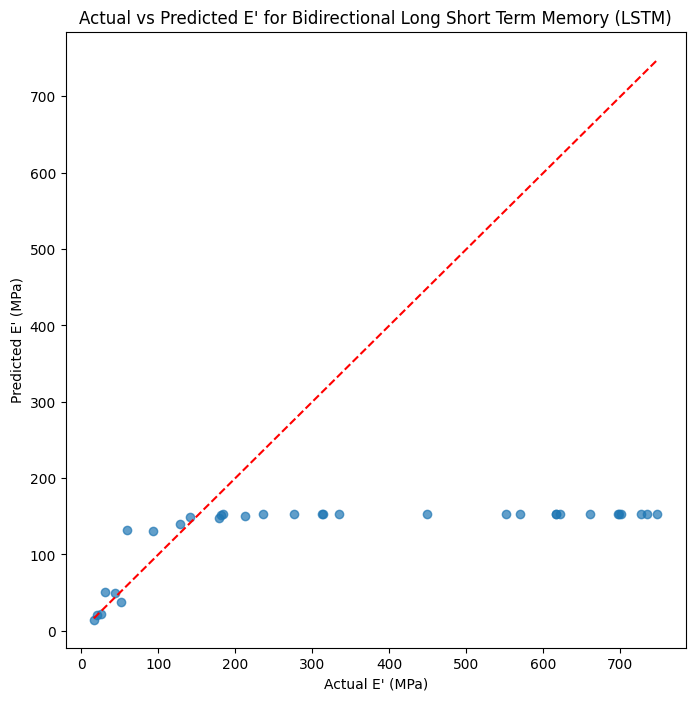

In [35]:

# Plot Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.xlabel("Actual E' (MPa)")
plt.ylabel("Predicted E' (MPa)")
plt.title("Actual vs Predicted E' for Bidirectional Long Short Term Memory (LSTM)")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Diagonal line
plt.show()

